In [28]:
import torch
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader
from scipy.io import loadmat
from torch import nn
from vqvae import VQVAE
from pixcnn import PixelCNN, PixelCNNWithEmbedding

In [29]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [30]:
class MNISTDataset(Dataset):
    def __init__(self, data, label, transform=None):
        self.data = data
        self.label = label
        self.transform = transform
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.transform(self.data[idx]), self.label[idx]

In [31]:
mnist = loadmat("../mnist-original.mat/mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]

In [32]:
EPOCHS = 100
batch_size = 64
num_workers = 8
lr = 1e-3
beta = 0.25
n_embedding = 32
embedding_dim = 32


In [33]:
model_vqvae = VQVAE(input_dim=1, dim=embedding_dim, n_embedding=n_embedding).to(device)
model_vqvae.load_state_dict(torch.load(f"/mnt/d/data/mnist_model/vqvae_lr_{lr}_nembedding_{n_embedding}_embedding_dim_{embedding_dim}_beta_{beta}.pth"))


/tmp/ipykernel_4131/1439498034.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vqvae.load_state_dict(torch.load(f"/mnt/d/data/mnist_model/vqvae_lr_{lr}_nembedding_

<All keys matched successfully>

In [34]:
model = PixelCNNWithEmbedding(n_embedding,embedding_dim, out_channels=n_embedding).to(device)
pixcnn_lr = 1e-3
pixcnn_epochs = 100


In [37]:
import wandb
wandb.login()

run =  wandb.init(
    project="vqvae_mnist_pixcnn",
    # entity="mnist_diffusion",
    name="pixcnn",
    config={
        "epochs": pixcnn_epochs,
        "batch_size": batch_size,
        "num_workers": num_workers,
        "lr": pixcnn_lr,
        "n_embedding": n_embedding,
        "embedding_dim": embedding_dim,
    }
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [55]:
from torch.nn import functional as F
from torch.nn.functional import one_hot
# def loss_function(logits, images):
#     loss = F.CrossEntropyLoss(logits, images)
#     return loss
def train(
        model: PixelCNNWithEmbedding,
        vqvae: VQVAE,
        optimizer: torch.optim.Optimizer,
        epochs: int,
        device: str,
        train_dataloader: DataLoader,
        val_dataloader: DataLoader,
):
    loss_function = nn.CrossEntropyLoss()
    vqvae.eval()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for index, (imgs, labels) in enumerate(val_dataloader):
                imgs = imgs.to(device)
                with torch.no_grad():
                    z_q_idx = vqvae.encode(imgs)
                predict_x = model(z_q_idx) 
                # predict_x = F.softmax(predict_x, dim=-1)
                loss = loss_function(predict_x, z_q_idx)    
                val_loss += loss.item()
        model.train(True)
        training_loss = 0
        for index, (imgs, labels) in enumerate(train_dataloader):
            imgs = imgs.to(device)
            with torch.no_grad():
                z_q_idx = vqvae.encode(imgs)

            # z_q_idx_one_hot = one_hot(z_q_idx, num_classes=n_embedding).to(device)
            predict_x = model(z_q_idx) 
            # predict_x = F.softmax(predict_x, dim=-1)
            loss = loss_function(predict_x, z_q_idx)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
        wandb.log({
            "epoch": epoch,
            "training_loss": training_loss / len(train_dataloader),
            "val_loss": val_loss / len(val_dataloader),
        })


In [56]:
from torch.utils.data import random_split
from torchvision import transforms

transform = transforms.Compose([
    transforms.Lambda(lambda x: x.reshape(28, 28)),
    transforms.ToTensor(),
    transforms.Pad((2, 2, 2, 2))  # Pad to 32x32
])
# Assuming mnist_data and mnist_label are already defined
dataset = MNISTDataset(mnist_data, mnist_label, transform=transform)

# Define the lengths for training and validation sets
train_size = 50000
val_size = 10000
# train_size = 500
# val_size = 100
test_size = len(dataset) - train_size - val_size
# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Now you can use train_dataset and val_dataset with DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [57]:
train(
    vqvae=model_vqvae,
    model=model,
    optimizer=torch.optim.Adam(params=model.parameters(), lr=pixcnn_lr),
    epochs=EPOCHS,
    device=device,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [58]:
torch.save(model.state_dict(), f"/mnt/d/data/mnist_model/vqvae_pixcnn_lr_{pixcnn_lr}_nembedding_{n_embedding}_embedding_dim_{embedding_dim}.pth")

    

In [89]:
C, H, W = 1, 32, 32
H, W = model_vqvae.get_latent_HW((C, H, W))
n_samples = 16
input_shape = (n_samples, H, W)
x = torch.zeros(input_shape).to(device).to(torch.long)

with torch.no_grad():
    model.eval()
    for i in range(H):
        for j in range(W):
            output = model(x)
            prob_dist = F.softmax(output[:, :, i, j], -1)
            pixel = torch.multinomial(prob_dist, 1)
            x[:, i, j] = pixel[:, 0]

imgs = model_vqvae.decode(x)

In [90]:
from matplotlib import pyplot as plt
import torchvision.utils as vutils
def show_images(images):
    grid = vutils.make_grid(images, nrow=4, padding=2, normalize=True)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0).cpu(), cmap='gray')  # 调整维度顺序
    plt.axis('off')
    plt.show()
    plt.close()
    

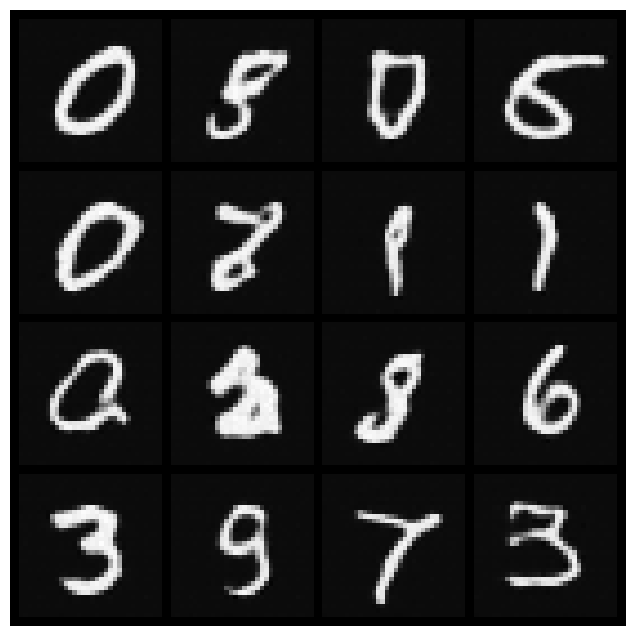

In [91]:
show_images(imgs)

In [98]:
result = torch.empty(10000, 1, 32, 32)
C, H, W = 1, 32, 32
H, W = model_vqvae.get_latent_HW((C, H, W))
n_samples = 100
input_shape = (n_samples, H, W)
x = torch.zeros(input_shape).to(device).to(torch.long)

with torch.no_grad():
    model.eval()
    for i in range(100):
        print(f"Generating batch {i+1}/100")
        with torch.no_grad():
            for h in range(H):
                for w in range(W):
                    output = model(x)
                    prob_dist = F.softmax(output[:, :, h, w], -1)
                    pixel = torch.multinomial(prob_dist, 1)
                    x[:, h, w] = pixel[:, 0]
        imgs = model_vqvae.decode(x)
        imgs = imgs.cpu()
        result[i*100:(i+1)*100] = imgs
        


Generating batch 1/100
Generating batch 2/100
Generating batch 3/100
Generating batch 4/100
Generating batch 5/100
Generating batch 6/100
Generating batch 7/100
Generating batch 8/100
Generating batch 9/100
Generating batch 10/100
Generating batch 11/100
Generating batch 12/100
Generating batch 13/100
Generating batch 14/100
Generating batch 15/100
Generating batch 16/100
Generating batch 17/100
Generating batch 18/100
Generating batch 19/100
Generating batch 20/100
Generating batch 21/100
Generating batch 22/100
Generating batch 23/100
Generating batch 24/100
Generating batch 25/100
Generating batch 26/100
Generating batch 27/100
Generating batch 28/100
Generating batch 29/100
Generating batch 30/100
Generating batch 31/100
Generating batch 32/100
Generating batch 33/100
Generating batch 34/100
Generating batch 35/100
Generating batch 36/100
Generating batch 37/100
Generating batch 38/100
Generating batch 39/100
Generating batch 40/100
Generating batch 41/100
Generating batch 42/100
G

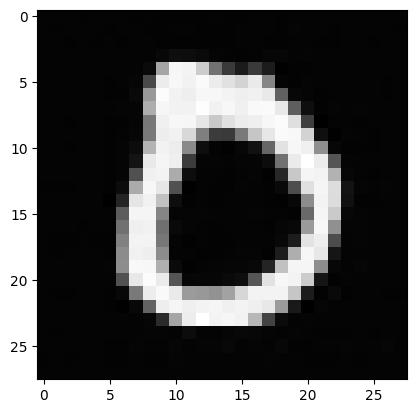

In [100]:
plt.imshow(result[200][0, 2:-2, 2:-2].squeeze().cpu().numpy(), cmap='gray')

In [104]:
result = (result-result.min())/(result.max()-result.min())

In [105]:
import tifffile as tif
import os
result_dir = "/mnt/d/data/mnist_result/vqvae_result/"
os.makedirs(result_dir, exist_ok=True)
from os.path import join as ospj
for i in range(result.shape[0]):
    tif.imwrite(ospj(result_dir, f"{str(i).zfill(5)}.tif"), result[i][0, 2:-2, 2:-2].squeeze().cpu().numpy())

In [106]:
test_dir = "/mnt/d/data/mnist_result/test_sample/"
result_dir = "/mnt/d/data/mnist_result/vqvae_result/"

real_images_folder = test_dir
# generated_images_folder = './FID_app3'
generated_images_folder = result_dir
import torch
from pytorch_fid import fid_score

fid_value = fid_score.calculate_fid_given_paths([real_images_folder, generated_images_folder],
                                                batch_size=50,
                                                device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
                                                dims=2048                                                 
                                                )
print("FID score:", fid_value)

100%|██████████| 200/200 [00:52<00:00,  3.84it/s]


FID score: 2.8502779525741113
